In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

Building the engine

In [2]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __rmul__(self,other):
    return self * other

  def __truediv__(self, other):
    return self * other ** -1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
        node._backward()

Initializing graphviz

In [3]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ['record'] node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            #if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            #and connect this node to it
            dot.edge(uid + n._op,uid)

    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)),str(id(n2)) + n2._op)

    return dot


Sample problem

In [4]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

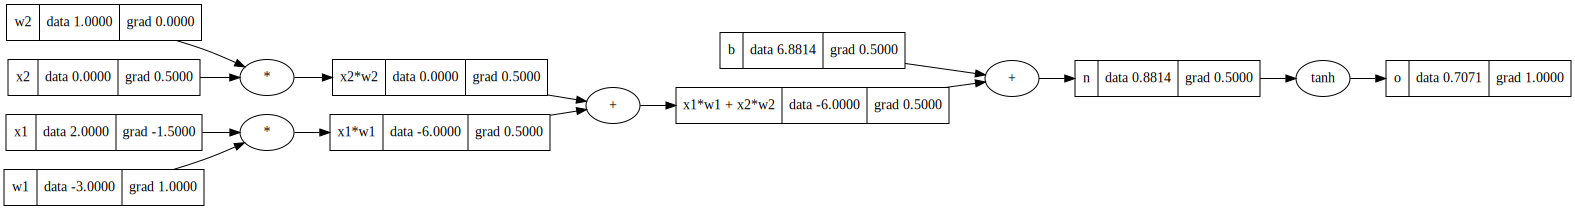

In [5]:
draw_dot(o)

Redoing the above example using PyTorch, to confirm our implementation

In [8]:
import torch

In [9]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


We have the same output, weights and data

---

Building neuron and layers

In [24]:
class Neuron:

  def __init__(self,nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range (nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self,x):
      # w * x + b
      act = sum((wi * xi for wi, xi in zip(self.w,x)), self.b)
      out = act.tanh()
      return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self,nin,nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs)==1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self,nin,nouts):
    size =[nin] + nouts
    self.layers = [Layer(size[i], size[i+1]) for i in range(len(nouts))]

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [25]:
x = [5.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.6476254618913647)

In [29]:
len(n.parameters())

41

Building example dataset to test the back propogation

In [30]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.622887401637358),
 Value(data=-0.7488212242047269),
 Value(data=0.6353468667289921),
 Value(data=-0.44934881820503497)]

Calculating loss by implementing MSE

In [44]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))
loss

Value(data=7.471825667155931)

In [82]:
for k in range(20):
  #forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))

  #backward pass
  for p in n.parameters(): #flushing previous p.grad value
    p.grad = 0.0
  loss.backward()

  #update
  for p in n.parameters():
    p.data += -0.5 * p.grad

  print(k,loss.data)

0 0.0004825588386144289
1 0.0004748398060523412
2 0.00046737212984371594
3 0.00046014345587076853
4 0.000453142239231274
5 0.0004463576783031744
6 0.00043977965520603586
7 0.0004333986819425201
8 0.0004272058515935183
9 0.0004211927940189535
10 0.00041535163558326836
11 0.0004096749624827199
12 0.00040415578730202924
13 0.0003987875184712242
14 0.00039356393233177053
15 0.0003884791475539895
16 0.0003835276016765511
17 0.00037870402956440767
18 0.00037400344360336707
19 0.00036942111546922136


In [83]:
ypred

[Value(data=0.9914043930578702),
 Value(data=-0.9976341696112089),
 Value(data=-0.9857856396061303),
 Value(data=0.990624955363824)]

Preds are now close to our desired targets

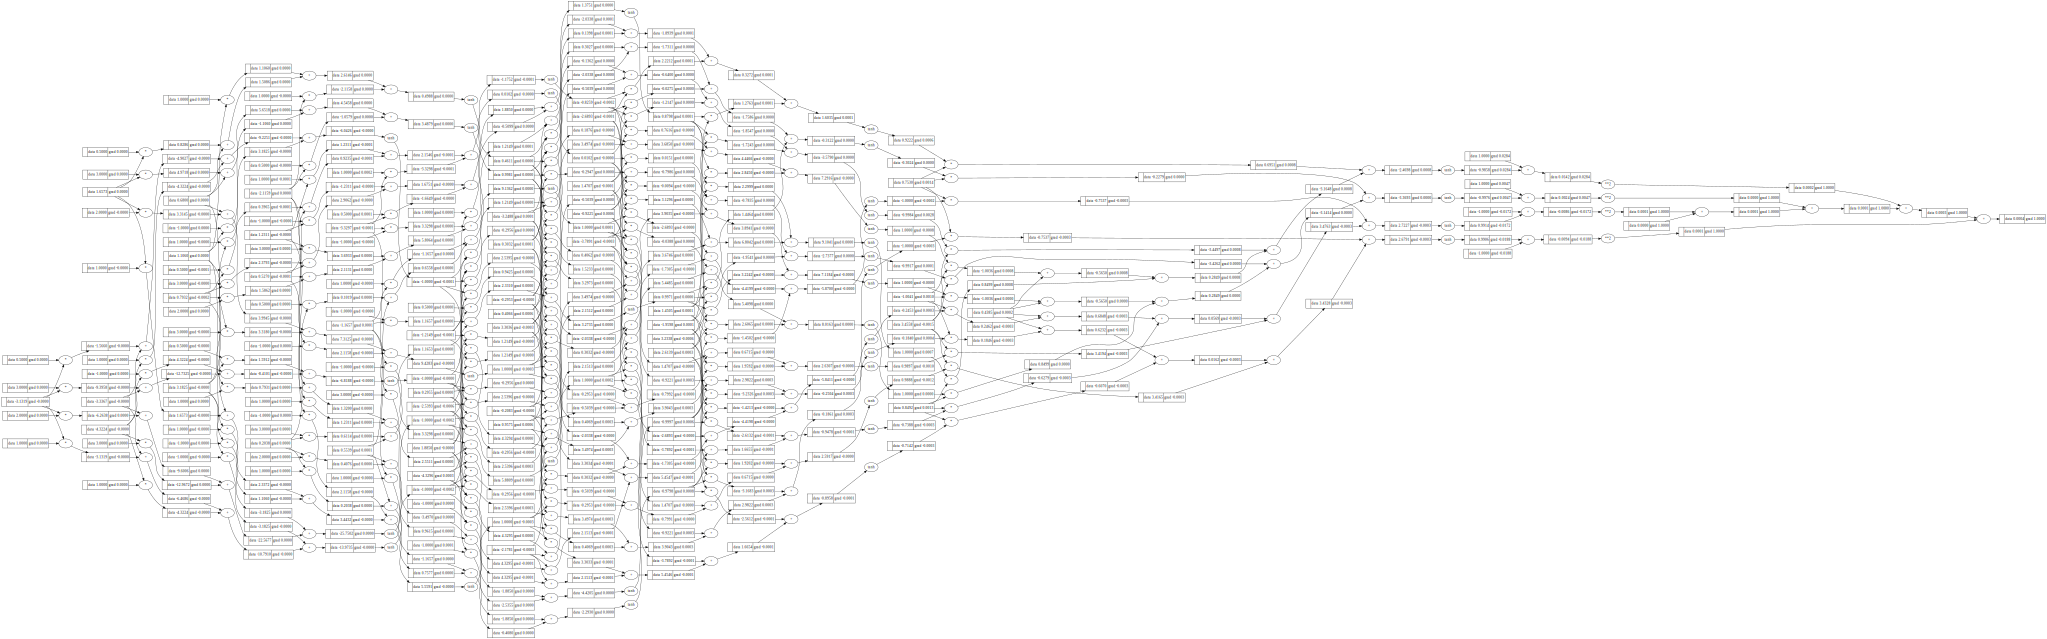

In [84]:
draw_dot(loss)

We have successfully built a neural network from scratch ✅